
  ****READING THE DATA


In [173]:

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight


In [174]:
x = r"C:\Users\zaxak\Desktop\Train.csv"
df = pd.read_csv(x)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


>DATA CLEAN




FEATURE ENGINEERING

In [175]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == 'object')

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(df[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(df[categorical_columns].head())


  Warehouse_block Mode_of_Shipment Product_importance Gender
0               D           Flight                low      F
1               F           Flight                low      M
2               A           Flight                low      M
3               B           Flight             medium      M
4               C           Flight             medium      F
   Warehouse_block  Mode_of_Shipment  Product_importance  Gender
0                3                 0                   1       0
1                4                 0                   1       1
2                0                 0                   1       1
3                1                 0                   2       1
4                2                 0                   2       0


In [176]:
cols_to_keep = [ 
     'Discount_offered', 'Weight_in_gms', 'Warehouse_block',
    'Reached.on.Time_Y.N', 'Customer_rating','Product_importance','Mode_of_Shipment'
]

# Create the final DataFrame with only numerical columns
df = df[cols_to_keep].copy()
df = df.rename(columns={'Reached.on.Time_Y.N': 'Target_On_Time'})

# Display the first few rows showing the new features
print("DataFrame with four new numerical combinations:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

DataFrame with four new numerical combinations:
| Discount_offered   | Weight_in_gms   | Warehouse_block   | Target_On_Time   | Customer_rating   | Product_importance   | Mode_of_Shipment   |
|:-------------------|:----------------|:------------------|:-----------------|:------------------|:---------------------|:-------------------|
| 44                 | 1233            | 3                 | 1                | 2                 | 1                    | 0                  |
| 59                 | 3088            | 4                 | 1                | 5                 | 1                    | 0                  |
| 48                 | 3374            | 0                 | 1                | 2                 | 1                    | 0                  |
| 10                 | 1177            | 1                 | 1                | 3                 | 2                    | 0                  |
| 46                 | 2484            | 2                 | 1                | 2       

DATA SPLIT

In [177]:
# Target variable (y): Select the column you want to predict
y = df['Target_On_Time']

# Features (X): Select all other columns by dropping the target variable
X = df.drop('Target_On_Time', axis=1)

In [178]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [179]:
from sklearn.preprocessing import StandardScaler

# 1. CRITICAL: SAVE the original column names BEFORE scaling
original_columns = X_train.columns

scaler = StandardScaler()

# 2. Fit and transform the training data
# This results in a NumPy array.
X_train_scaled_array = scaler.fit_transform(X_train)

# 3. Convert the scaled array back to a DataFrame, 
#    re-applying the original column names
X_train = pd.DataFrame(X_train_scaled_array, columns=original_columns)

# 4. Transform X_test using the same fitted scaler
X_test_scaled_array = scaler.transform(X_test)

# 5. Convert X_test back to a DataFrame (assuming X_test also needs column names)
#    Note: X_test's original columns should be the same as X_train's
X_test = pd.DataFrame(X_test_scaled_array, columns=original_columns)

# X_train and X_test are now scaled DataFrames with their column names intact.

****MODEL CREATION*******

In [180]:
#RANDOM FOREST CLASSIFIER


rf_model = RandomForestClassifier(random_state=42).fit(
  X_train, y_train)

# Use it to predict the labels of the test data
rf_predictions = rf_model.predict(X_test)
y_probalities_RF = rf_model.predict_proba(X_test)
y_probs_rf = y_probalities_RF[:, 1]


In [181]:
print('accuracy:',accuracy_score(y_test,rf_predictions))
print('f1:',f1_score(y_test,rf_predictions))
print(confusion_matrix(y_test,rf_predictions))
print('recall:',recall_score(y_test,rf_predictions))
print('precision:',precision_score(y_test,rf_predictions))
print('auc:',roc_auc_score(y_test,y_probs_rf))

accuracy: 0.6386363636363637
f1: 0.6883575068600549
[[527 360]
 [435 878]]
recall: 0.6686976389946687
precision: 0.7092084006462036
auc: 0.7236991802553769


In [182]:
#SVM
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train, y_train)

# Get predictions and probabilities
svc_predictions = svc_model.predict(X_test)
svc_probabilities = svc_model.predict_proba(X_test)[:, 1] 

# Evaluate Baseline Performance
print("--- SVC BASELINE METRICS (Default Settings) ---")
print('Accuracy:', accuracy_score(y_test, svc_predictions))
print('F1:', f1_score(y_test, svc_predictions))
print('AUC:', roc_auc_score(y_test, svc_probabilities))
print('Confusion Matrix:\n', confusion_matrix(y_test, svc_predictions))
print('Recall:', recall_score(y_test, svc_predictions))
print('Precicion:',precision_score(y_test, svc_predictions))

--- SVC BASELINE METRICS (Default Settings) ---
Accuracy: 0.6731818181818182
F1: 0.6957257723233178
AUC: 0.7421427902915172
Confusion Matrix:
 [[659 228]
 [491 822]]
Recall: 0.6260472201066261
Precicion: 0.7828571428571428


In [183]:
#LOGISTIC REGRESIION
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression().fit(X_train,y_train)
log_preds=log_reg.predict(X_test)
y_probalities_log = log_reg.predict_proba(X_test)
y_probs_log = y_probalities_log[:, 1]


In [184]:
print('accuracy:',accuracy_score(y_test,log_preds))
print('f1:',f1_score(y_test,log_preds))
print(confusion_matrix(y_test,log_preds))
print('recall:',recall_score(y_test,log_preds))
print('precision:',precision_score(y_test,log_preds))
print('auc:',roc_auc_score(y_test,y_probs_log))

accuracy: 0.6281818181818182
f1: 0.6831913245546088
[[500 387]
 [431 882]]
recall: 0.6717440974866717
precision: 0.6950354609929078
auc: 0.7134740531550336


In [185]:
#KNN
import matplotlib.pyplot as plt
from sklearn.neighbors  import KNeighborsClassifier


	# Set up a KNN Classifier
knn = KNeighborsClassifier().fit(X_train,y_train)
  #  accuracy
knn_predicts=knn.predict(X_test)
y_probalities_knn = knn.predict_proba(X_test)
y_probs_knn = y_probalities_knn[:, 1]




In [186]:
print('accuracy:',accuracy_score(y_test,knn_predicts))
print('f1:',f1_score(y_test,knn_predicts))
print(confusion_matrix(y_test,knn_predicts))
print('recall:',recall_score(y_test,knn_predicts))
print('precision:',precision_score(y_test,knn_predicts))
print('auc:',roc_auc_score(y_test,y_probs_knn))

accuracy: 0.639090909090909
f1: 0.6849206349206349
[[543 344]
 [450 863]]
recall: 0.6572734196496572
precision: 0.7149958574979287
auc: 0.7061601485792495


In [ ]:
#DECISION TREE
Dec_Tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
predictions=Dec_Tree.predict(X_test)
y_probalities_dec = Dec_Tree.predict_proba(X_test)
y_probs_dec = y_probalities_dec[:, 1]

In [188]:
print('accuracy:',accuracy_score(y_test,predictions))
print('f1:',f1_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print('recall:',recall_score(y_test,predictions))
print('precision:',precision_score(y_test,predictions))
print('auc:',roc_auc_score(y_test,y_probs_dec))

accuracy: 0.6477272727272727
f1: 0.6994959286545173
[[523 364]
 [411 902]]
recall: 0.686976389946687
precision: 0.7124802527646129
auc: 0.6383502585797561


In [ ]:
#XGBOOST
from xgboost import XGBClassifier
Xgboost=XGBClassifier(random_state=42).fit(X_train,y_train)
Xg_preds=Xgboost.predict(X_test)
y_probalities_xg = Xgboost.predict_proba(X_test)
y_probs_xg = y_probalities_xg[:, 1]

In [190]:
print('accuracy:',accuracy_score(y_test,Xg_preds))
print('f1:',f1_score(y_test,Xg_preds))
print(confusion_matrix(y_test,Xg_preds))
print('recall:',recall_score(y_test,Xg_preds))
print('precision:',precision_score(y_test,Xg_preds))
print('auc:',roc_auc_score(y_test,y_probs_xg))

accuracy: 0.6631818181818182
f1: 0.6996351844345359
[[596 291]
 [450 863]]
recall: 0.6572734196496572
precision: 0.7478336221837089
auc: 0.7338367259672806


#*****************HYPERPARAMETERS

In [191]:
#What are the hyperparameters for each model ?
#KNN
print('KNN:',knn.get_params().keys())
#RANDOM FOREST CLASSIFIER
print('Random Forest:',rf_model.get_params().keys())
print('Decision Tree:',Dec_Tree.get_params().keys())
print('Xgboost',Xgboost.get_params().keys())
print('Logistic regression:',log_reg.get_params().keys())
print('SVM:',svc_model.get_params().keys())

KNN: dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])
Random Forest: dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Decision Tree: dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])
Xgboost dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_cons

DECISION TREE TUNING


In [192]:
#GRIDSEARCH FOR DECICION TREE
param_grid_DCT={'criterion' : ["gini", "entropy",'log_loss'],
               'max_depth' : [None, 5, 10, 20],
               'max_features' : ['sqrt','log2'],
               'min_samples_leaf' : [1,5,10,20],
            }
                
grid_DCT=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid_DCT,cv=5,n_jobs=-1,scoring='accuracy',error_score='raise')
grid_DCT.fit(X_train,y_train)
grid_DCT.best_params_


{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 20}

In [193]:
best_params = {'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 20}

Dec_Tree_tuned=DecisionTreeClassifier(**best_params,random_state=42) 
Dec_Tree_tuned.fit(X_train,y_train)
predict=Dec_Tree_tuned.predict(X_test)

y_proba_all_dec = Dec_Tree_tuned.predict_proba(X_test)
y_scores_dec = y_proba_all_dec[:, 1]


In [194]:
print('accuracy:',accuracy_score(y_test,predict))
print('f1:',f1_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print('recall:',recall_score(y_test,predict))
print('precision:',precision_score(y_test,predict))
print('AUC',roc_auc_score(y_test,y_scores_dec))

accuracy: 0.6777272727272727
f1: 0.6986825329366766
[[669 218]
 [491 822]]
recall: 0.6260472201066261
precision: 0.7903846153846154
AUC 0.7414086521825367


*KNN TUNING and complexity visualization


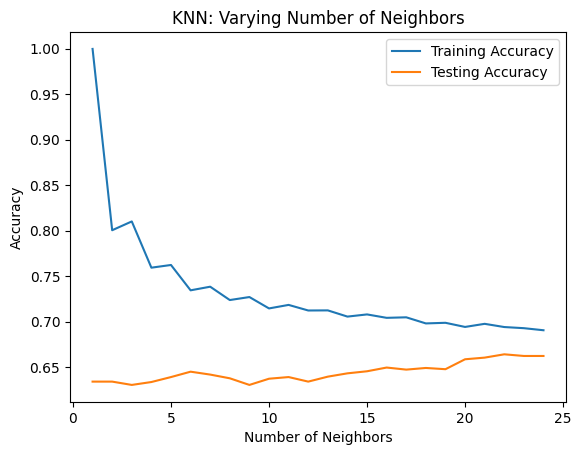

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
 {np.int64(1): 0.9996590521650187, np.int64(2): 0.8004318672576429, np.int64(3): 0.810092055915445, np.int64(4): 0.759290828503239, np.int64(5): 0.7622457097397431, np.int64(6): 0.7344016365496079, np.int64(7): 0.7383793612910557, np.int64(8): 0.7237186043868622, np.int64(9): 0.7270144334583475, np.int64(10): 0.7145130128423685, np.int64(11): 0.7183770883054893, np.int64(12): 0.7122400272758268, np.int64(13): 0.7123536765541539, np.int64(14): 0.7055347198545289, np.int64(15): 0.7079213546993977, np.int64(16): 0.7041709285146039, np.int64(17): 0.7047391749062394, np.int64(18): 0.6980338674849415, np.int64(19): 0.6987157631549039, np.int64(20): 0.6941697920218206, np.int64(21): 0.6975792703716331, np.int64(22): 0.6940561427434936, np.int64(23): 0.6928060006818957, np.int64(24): 0.690533015115354} 
 {np.int64(1): 0.634090909090909, np.int64(2): 0.634090909090909, np.int64(3): 0.6304545454545455, np.int64(4): 0.6336

In [195]:
neighbors = np.arange(1, 25)
train_accuracies = {}
test_accuracies = {}
for neighbor in neighbors:
  
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor)
  
	# Fit the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)

# PLOT MODEL COMPLEXITY
plt.title("KNN: Varying Number of Neighbors")

# Plot training accuracies
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)


In [196]:
# Find the key corresponding to the maximum value
best_key = max(test_accuracies, key=test_accuracies.get)
best_value = test_accuracies[best_key]

print(f"K={best_key} is the best value for the hyperparameter 'n_neighbors', to maximize accuracy ")
print(f"Highest value: {best_value:.4f}")


K=22 is the best value for the hyperparameter 'n_neighbors', to maximize accuracy 
Highest value: 0.6641


In [ ]:
#More KNN hyperparameters to tune
param_grid_KNN={'n_neighbors': range(1,26),
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [20,30,40]
}
grid_knn=GridSearchCV(KNeighborsClassifier(),param_grid_KNN,cv=5,n_jobs=-1,scoring='accuracy')
grid_knn.fit(X_train,y_train)
grid_knn.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 20,
 'n_neighbors': 22,
 'weights': 'uniform'}

In [198]:
best_knn_params={'algorithm': 'ball_tree',
 'leaf_size': 20,
 'n_neighbors': 22,
 }
Tuned_KNN=KNeighborsClassifier(**best_knn_params)
Tuned_KNN.fit(X_train,y_train)
KNN_predictionS=Tuned_KNN.predict(X_test)
y_proba_all_KNN = Tuned_KNN.predict_proba(X_test)
y_scores_KNN = y_proba_all_KNN[:, 1]

In [199]:
print('accuracy:',accuracy_score(y_test,KNN_predictionS))
print('f1:',f1_score(y_test,KNN_predictionS))
print(confusion_matrix(y_test,KNN_predictionS))
print('recall:',recall_score(y_test,KNN_predictionS))
print('precision:',precision_score(y_test,KNN_predictionS))
print('AUC',roc_auc_score(y_test,y_scores_KNN))

accuracy: 0.6640909090909091
f1: 0.682968682968683
[[665 222]
 [517 796]]
recall: 0.6062452399086062
precision: 0.7819253438113949
AUC 0.7280198620850725


**RANDOMFOREST TUNE


In [200]:
# RANDOM FOREST TUNING
param_grid_RF = {'n_estimators': range(10, 50, 10),
'criterion' : ["gini", "entropy",'log_loss'],
'max_depth' : [None, 5, 10, 20],
'bootstrap' : [True, False],
'min_samples_split' : [2,5,10,20],
'max_features' : ['sqrt','log2']
}

# Optimize for a RandomForestClassifier() using GridSearchCV
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_RF, cv=5,n_jobs=-1,scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 20,
 'n_estimators': 20}

In [201]:
best_rf_params={'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 20,
 'n_estimators': 20}
Tuned_RF=RandomForestClassifier(**best_rf_params,random_state=42,n_jobs=-1)
Tuned_RF.fit(X_train,y_train)
rf_tuned_predictions=Tuned_RF.predict(X_test)
y_proba_all_RF = Tuned_RF.predict_proba(X_test)
y_scores_RF = y_proba_all_RF[:, 1]




In [202]:
print('accuracy:',accuracy_score(y_test,rf_tuned_predictions))
print('f1:',f1_score(y_test,rf_tuned_predictions))
print(confusion_matrix(y_test,rf_tuned_predictions))
print('recall:',recall_score(y_test,rf_tuned_predictions))
print('precision:',precision_score(y_test,rf_tuned_predictions))
print('AUC',roc_auc_score(y_test,y_scores_RF))

accuracy: 0.6786363636363636
f1: 0.6972162740899358
[[679 208]
 [499 814]]
recall: 0.61995430312262
precision: 0.7964774951076321
AUC 0.7476999152521271


*LOG REGRESSION TUNE


In [ ]:
param_grid_lg ={
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000], 
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
   
   
grid_search_lg = GridSearchCV(LogisticRegression(solver='liblinear'),
    param_grid_lg,
    scoring='accuracy',
    cv=5,                 # Use 5-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all available CPU cores
)
grid_search_lg.fit(X_train, y_train)
grid_search_lg.best_params_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

In [204]:
lg_best={'C': 0.001, 'max_iter': 2000, 'penalty': 'l2'}


Tuned_lg=LogisticRegression(**lg_best,random_state=42,solver='saga')
Tuned_lg.fit(X_train,y_train)
LG_tuned_predictions=Tuned_lg.predict(X_test)
y_proba_all_lg = Tuned_lg.predict_proba(X_test)
y_scores_lg = y_proba_all_lg[:, 1]


In [205]:
print(confusion_matrix(y_test,LG_tuned_predictions))
print('PRECICION:',precision_score(y_test,LG_tuned_predictions))
print('f1:',f1_score(y_test,LG_tuned_predictions))
print('recall',recall_score(y_test,LG_tuned_predictions))
print('accuracy',accuracy_score(y_test,LG_tuned_predictions))
y=roc_auc_score(y_test,y_scores_lg)
print('AUC',y)

[[ 415  472]
 [ 286 1027]]
PRECICION: 0.6851234156104069
f1: 0.7304409672830725
recall 0.7821782178217822
accuracy 0.6554545454545454
AUC 0.7327376654064678


****SVM TUNE

In [206]:

param_grid_SVC = {
    'C': [0.1, 1, 10],            
    'kernel': ['rbf', 'poly'],    
    'gamma': ['scale', 'auto']    
}


grid_SVC = GridSearchCV(
    SVC(random_state=42, probability=True), 
    param_grid_SVC, 
    cv=5,                      
    n_jobs=-1,                 
)

grid_SVC.fit(X_train, y_train)
grid_SVC.best_params_





{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [207]:
svm_best={'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Tuned_svm=SVC(**svm_best,random_state=42,probability=True)
Tuned_svm.fit(X_train,y_train)
SVM_tuned_predictions=Tuned_svm.predict(X_test)
y_proba_all_svm1 = Tuned_svm.predict_proba(X_test)
y_scores_svm1 = y_proba_all_svm1[:, 1]

In [208]:
print(confusion_matrix(y_test,SVM_tuned_predictions))
print('PRECICION:',precision_score(y_test,SVM_tuned_predictions))
print('f1:',f1_score(y_test,SVM_tuned_predictions))
print('recall',recall_score(y_test,SVM_tuned_predictions))
print('accuracy',accuracy_score(y_test,SVM_tuned_predictions))
y=roc_auc_score(y_test,y_scores_svm1)
print('AUC',y)

[[659 228]
 [491 822]]
PRECICION: 0.7828571428571428
f1: 0.6957257723233178
recall 0.6260472201066261
accuracy 0.6731818181818182
AUC 0.7421427902915172



***XGBOOST TUNE


In [209]:
param_grid_XG = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma':[0, 0.1, 0.2],
        'min_child_weight':[1, 3, 5, 7],
        'grow_policy':['depthwise','lossguide']
}
        
grid_XG = GridSearchCV(XGBClassifier(random_state=42), param_grid_XG, cv=5,n_jobs=-1,scoring='accuracy')
grid_XG.fit(X_train, y_train)
grid_XG.best_params_


{'gamma': 0,
 'grow_policy': 'depthwise',
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1}

In [210]:
xg_best={'gamma': 0,
 'grow_policy': 'depthwise',
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1}
Tuned_xg=XGBClassifier(**xg_best,random_state=42,n_jobs=-1)
Tuned_xg.fit(X_train,y_train)
XG_tuned_predictions=Tuned_xg.predict(X_test)
y_proba_all = Tuned_xg.predict_proba(X_test)
y_scores = y_proba_all[:, 1]


In [211]:
print(confusion_matrix(y_test,XG_tuned_predictions))
print('PRECICION:',precision_score(y_test,XG_tuned_predictions))
print('f1:',f1_score(y_test,XG_tuned_predictions))
print('recall',recall_score(y_test,XG_tuned_predictions))
print('accuracy',accuracy_score(y_test,XG_tuned_predictions))
y=roc_auc_score(y_test,y_scores)
print('auc',y)



[[614 273]
 [426 887]]
PRECICION: 0.7646551724137931
f1: 0.7173473513950667
recall 0.6755521706016756
accuracy 0.6822727272727273
auc 0.7468605936129126


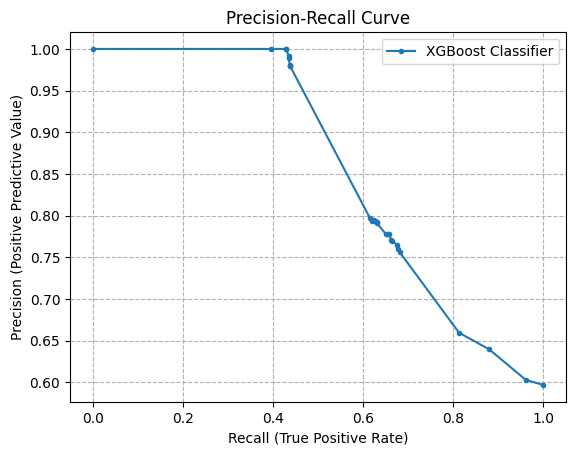

In [212]:
precision, recall, thresholds = precision_recall_curve( y_test,y_scores )
plt.plot(recall, precision, marker='.', label='XGBoost Classifier')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.grid(True, linestyle='--')

plt.legend()



In [272]:
# Define your new optimal threshold
OPTIMAL_THRESHOLD = 0.5335

# Convert probability scores (y_scores) into binary predictions (0 or 1)
# 1 if score >= threshold, else 0
y_pred_new = np.where(y_scores >= OPTIMAL_THRESHOLD, 1, 0)
new_recall = recall_score(y_test, y_pred_new)
new_precision = precision_score(y_test, y_pred_new)
new_cm = confusion_matrix(y_test, y_pred_new)
print('f1',f1_score(y_test, y_pred_new))
print('accuracy',accuracy_score(y_test, y_pred_new))
print('AUC',roc_auc_score(y_test,y_scores))


print(f"--- Performance at Threshold {OPTIMAL_THRESHOLD} ---")
print(f"New Recall:    {new_recall:.4f}")
print(f"New Precision: {new_precision:.4f}")
print(f"Confusion Matrix:\n{new_cm}")

f1 0.6944563816072196
accuracy 0.6768181818181818
AUC 0.7468605936129126
--- Performance at Threshold 0.5335 ---
New Recall:    0.6154
New Precision: 0.7968
Confusion Matrix:
[[681 206]
 [505 808]]


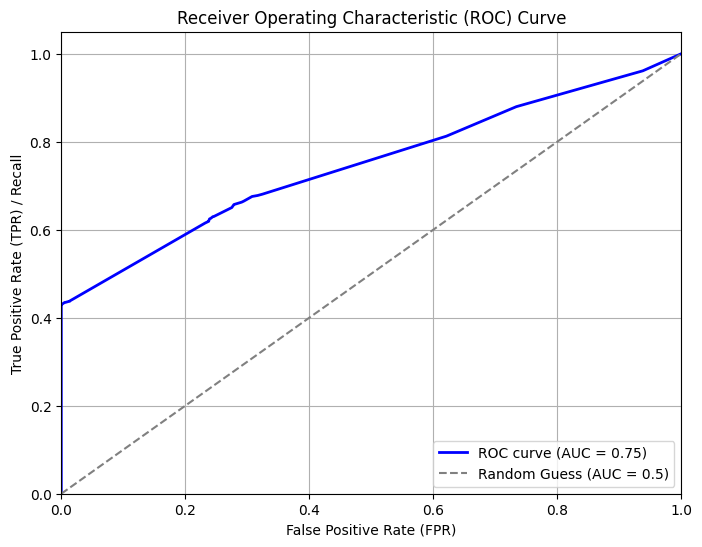

In [273]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = 0.75)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()